<a href="https://colab.research.google.com/github/jessecanada/MAPS/blob/master/convolution_manifold_clustering_cropping.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
import random

In [0]:
!unzip /content/drive/My\ Drive/PTEN_images/M134I_singles_RGB.zip -d /content/

Archive:  /content/drive/My Drive/PTEN_images/M134I_singles_RGB.zip
   creating: /content/M134I_singles_RGB/
  inflating: /content/M134I_singles_RGB/merged_191029120001_B03f101_3.jpg  
  inflating: /content/M134I_singles_RGB/merged_191029120001_B03f132_3.jpg  
  inflating: /content/M134I_singles_RGB/merged_191029120001_B03f220_1.jpg  
  inflating: /content/M134I_singles_RGB/merged_191029120001_B03f207_1.jpg  
  inflating: /content/M134I_singles_RGB/merged_191029120001_B03f70_2.jpg  
  inflating: /content/M134I_singles_RGB/merged_191029120001_B03f152_3.jpg  
  inflating: /content/M134I_singles_RGB/merged_191029120001_B03f61_2.jpg  
  inflating: /content/M134I_singles_RGB/merged_191029120001_B03f159_3.jpg  
  inflating: /content/M134I_singles_RGB/merged_191029120001_B03f72_0.jpg  
  inflating: /content/M134I_singles_RGB/merged_191029120001_B03f72_2.jpg  
  inflating: /content/M134I_singles_RGB/merged_191029120001_B03f151_2.jpg  
  inflating: /content/M134I_singles_RGB/merged_191029120001

In [0]:
# confirm how many cells are to be analyzed
!ls M134I_singles_RGB | wc -l

551


## Import images and extract image features

In [0]:
from pathlib import Path

rootdir = Path('/content/M134I_singles_RGB/')

file_list = [f for f in rootdir.glob('*.jpg') if f.is_file()]

In [0]:
samples = []
originals = []
img_ID = []

mag_layer = []
angle_layer = []
edge_layer = []

for fname in file_list:
    img = cv2.imread(fname.as_posix(), -1)
  
    # set blue and green channels to 0. cv2 works in BGR
    img[:, :, 0] = 0
    img[:, :, 1] = 0

    # convert image to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    samples.append((gray/255.0).reshape(-1)) #flatten image to 1D
    originals.append(gray)
    img_ID.append(fname.name[:-4])

    # calculate image gradient
    gx = cv2.Sobel(gray, cv2.CV_32F, 1, 0, ksize=1)
    gy = cv2.Sobel(gray, cv2.CV_32F, 0, 1, ksize=1)

    # calculate gradient magnitude and direction ( in degrees ) 
    mags, angles = cv2.cartToPolar(gx, gy, angleInDegrees=True)
    
    # calculate the dges
    edges = cv2.Canny(gray, 100, 200)
    
    mag_layer.append((mags).reshape(-1))
    angle_layer.append((angles).reshape(-1))
    edge_layer.append((edges).reshape(-1))

## Build image features into a DataFrame

In [0]:
df = pd.DataFrame(samples) # each row is an image, with cols being flattend 1D image array
df.insert(0, 'images', originals) # putting the original image in for plotting later

### Turn each convolutional layers into a df and concat

In [0]:
df_mag = pd.DataFrame(mag_layer)

df_angle = pd.DataFrame(angle_layer)

df_edge = pd.DataFrame(edge_layer)

In [0]:
layers = [df, df_mag, df_angle, df_edge]

df_all_layers = pd.concat(layers, axis=1, )

In [0]:
df_all_layers.head()

,images,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,...,20224,20225,20226,20227,20228,20229,20230,20231,20232,20233,20234,20235,20236,20237,20238,20239,20240,20241,20242,20243,20244,20245,20246,20247,20248,20249,20250,20251,20252,20253,20254,20255,20256,20257,20258,20259,20260,20261,20262,20263
0,"[[16, 16, 16, 17, 17, 17, 16, 16, 16, 16, 16, ...",0.062745,0.062745,0.062745,0.066667,0.066667,0.066667,0.062745,0.062745,0.062745,0.062745,0.062745,0.062745,0.066667,0.066667,0.066667,0.062745,0.062745,0.066667,0.066667,0.066667,0.070588,0.070588,0.066667,0.066667,0.062745,0.058824,0.062745,0.062745,0.066667,0.066667,0.066667,0.066667,0.066667,0.066667,0.066667,0.070588,0.066667,0.062745,0.062745,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,"[[13, 12, 11, 11, 11, 11, 11, 11, 11, 11, 11, ...",0.050980,0.047059,0.043137,0.043137,0.043137,0.043137,0.043137,0.043137,0.043137,0.043137,0.043137,0.043137,0.050980,0.050980,0.050980,0.050980,0.054902,0.054902,0.058824,0.058824,0.058824,0.062745,0.066667,0.062745,0.062745,0.062745,0.062745,0.066667,0.066667,0.062745,0.062745,0.062745,0.062745,0.058824,0.062745,0.062745,0.062745,0.058824,0.062745,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,"[[8, 9, 9, 9, 8, 8, 8, 7, 7, 7, 7, 7, 8, 8, 8,...",0.031373,0.035294,0.035294,0.035294,0.031373,0.031373,0.031373,0.027451,0.027451,0.027451,0.027451,0.027451,0.031373,0.031373,0.031373,0.031373,0.031373,0.031373,0.031373,0.031373,0.035294,0.035294,0.035294,0.035294,0.031373,0.031373,0.035294,0.035294,0.039216,0.035294,0.035294,0.031373,0.031373,0.035294,0.035294,0.035294,0.035294,0.039216,0.039216,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,"[[9, 9, 9, 9, 9, 9, 10, 10, 10, 10, 10, 10, 10...",0.035294,0.035294,0.035294,0.035294,0.035294,0.035294,0.039216,0.039216,0.039216,0.039216,0.039216,0.039216,0.039216,0.039216,0.039216,0.035294,0.035294,0.035294,0.031373,0.031373,0.031373,0.031373,0.027451,0.027451,0.031373,0.031373,0.031373,0.027451,0.027451,0.031373,0.031373,0.031373,0.031373,0.027451,0.031373,0.031373,0.035294,0.031373,0.035294,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,"[[10, 10, 10, 10, 10, 9, 9, 9, 9, 10, 10, 10, ...",0.039216,0.039216,0.039216,0.039216,0.039216,0.035294,0.035294,0.035294,0.035294,0.039216,0.039216,0.039216,0.039216,0.039216,0.043137,0.039216,0.039216,0.039216,0.043137,0.043137,0.047059,0.050980,0.050980,0.050980,0.047059,0.043137,0.047059,0.050980,0.054902,0.054902,0.054902,0.058824,0.054902,0.050980,0.050980,0.050980,0.050980,0.047059,0.050980,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [0]:
# pad with 0
df_all_layers.fillna(0, inplace=True)

In [0]:
# anymroe nan left?
df_all_layers.isna().sum().sum()

0

## Manifold learning

In [0]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import SpectralClustering 
from matplotlib.offsetbox import AnnotationBbox, OffsetImage
import timeit

### PCA followed by t-SNE

In [0]:
# PCA
start = timeit.default_timer()
prePCA= PCA(n_components=50, svd_solver= 'full').fit_transform(df_all_layers.iloc[:, 2:])
stop = timeit.default_timer()
print(f'run time = {(stop-start):.2f}s')

run time = 10.22s


In [0]:
# t-SNE
start = timeit.default_timer()
PCA_TSNE = TSNE(n_components=2, perplexity=30, n_iter=1000).fit_transform(prePCA)
stop = timeit.default_timer()
print(f'run time = {(stop-start):.2f}s')

run time = 2.77s


In [0]:
# converting results to DataFrame
X_PCA_TSNE = pd.DataFrame(PCA_TSNE)
X_PCA_TSNE.columns = ['P1', 'P2']

X_PCA_TSNE.head()

,P1,P2
0,-10.798709,2.278910
1,-15.960981,-1.215370
2,-16.845776,3.028539
3,-15.016526,-0.144437
4,-14.305861,15.362562


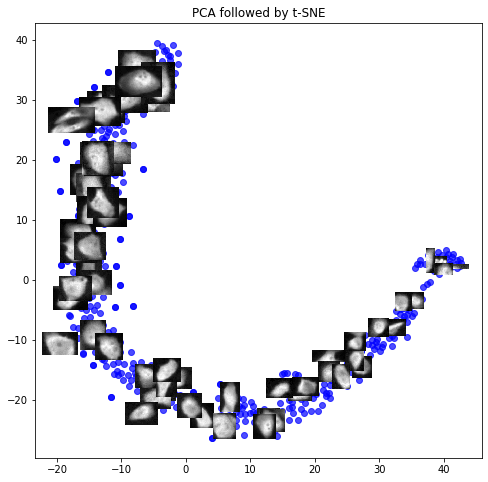

In [0]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
ax.scatter(PCA_TSNE[:,0], PCA_TSNE[:,1], marker='o', c='b', alpha=0.7)
ax.set_title('PCA followed by t-SNE')

# plot random images
num_to_plot = 60
num_images = len(df)
x=0; y=1

for i in range(num_to_plot):
    img_num = int(random.random() * num_images)
    #print(img_num)
    x = X_PCA_TSNE.iloc[img_num,0]
    y = X_PCA_TSNE.iloc[img_num,1]
    #print((x0, x1, y0, y1))
    imbox = OffsetImage(df_all_layers.iloc[img_num,0], zoom=0.35, cmap='gray')
    ab = AnnotationBbox(imbox, (x,y), xycoords='data', frameon=False)
    ax.add_artist(ab)
    
#plt.savefig('PCA before t-SNE.png', format='png', dpi=100, bbox_inches='tight')
plt.show(); plt.close()

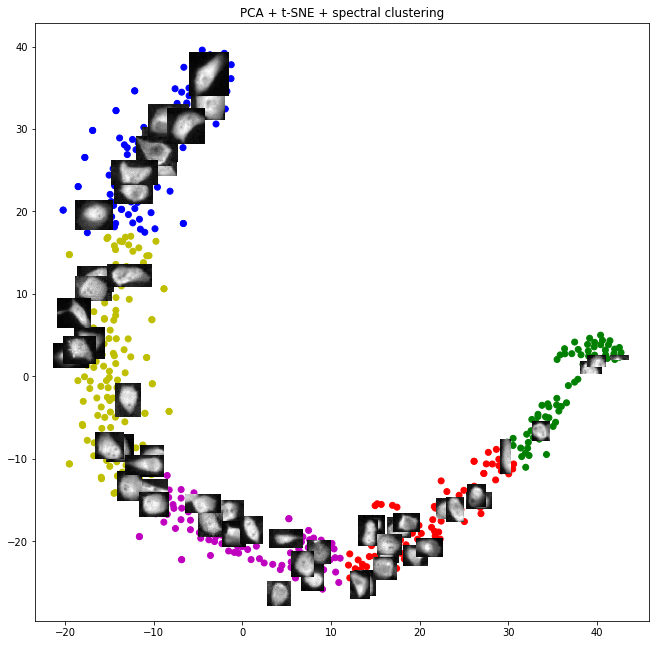

run time = 111.44s


In [0]:
# spectral clustering based on PCA
start = timeit.default_timer()

# Building the clustering model 
spectral_model_nn = SpectralClustering(n_clusters=5, affinity='nearest_neighbors') 
  
# Training the model and Storing the predicted cluster labels 
labels_nn = spectral_model_nn.fit_predict(X_PCA_TSNE) 

# Building the label to colour mapping 
colours = {} 
colours[0] = 'b'
colours[1] = 'y'
colours[2] = 'r'
colours[3] = 'g'
colours[4] = 'm'
  
# Building the colour vector for each data point 
cvec = [colours[label] for label in labels_nn] 
  
# Plotting the clustered scatter plot 
fig, ax = plt.subplots(1,1, figsize =(11, 11)) 
ax.scatter(X_PCA_TSNE['P1'], X_PCA_TSNE['P2'], c = cvec) 
ax.set_title('PCA + t-SNE + spectral clustering')

# plot random images
num_to_plot = 60
num_images = len(df)
x=0; y=1

for i in range(num_to_plot):
    img_num = int(random.random() * num_images)
    #print(img_num)
    x = X_PCA_TSNE.iloc[img_num,0]
    y = X_PCA_TSNE.iloc[img_num,1]
    #print((x0, x1, y0, y1))
    imbox = OffsetImage(df_all_layers.iloc[img_num,0], zoom=0.35, cmap='gray')
    ab = AnnotationBbox(imbox, (x,y), xycoords='data', frameon=False)
    ax.add_artist(ab)
    
#plt.savefig('PCA+tSNE+spectral_clustering.png', format='png', dpi=100, bbox_inches='tight')
plt.show() 
plt.close()
stop = timeit.default_timer()
print(f'run time = {(stop-start):.2f}s')

In [0]:
df_clusters = pd.DataFrame({'cluster_labels':labels_nn, 'image_ID':img_ID})
print(df_clusters.head())

   cluster_labels                       image_ID
0               1  merged_191029120001_B03f219_1
1               1   merged_191029120001_B03f42_3
2               1   merged_191029120001_B03f40_1
3               1  merged_191029120001_B03f299_1
4               1  merged_191029120001_B03f297_7


In [0]:
df_clusters.to_csv('M134I_cluster_labels.csv', index=False)

## Extract the needed clusters

In [0]:
df0 = df_clusters.loc[df_clusters['cluster_labels'] == 0].reset_index(drop=True)
df1 = df_clusters.loc[df_clusters['cluster_labels'] == 1].reset_index(drop=True)
df2 = df_clusters.loc[df_clusters['cluster_labels'] == 2].reset_index(drop=True)
df4 = df_clusters.loc[df_clusters['cluster_labels'] == 4].reset_index(drop=True)

In [0]:
print(df0.head(), '\n', df1.head())

   cluster_labels                       image_ID
0               0  merged_191029120001_B03f132_3
1               0   merged_191029120001_B03f66_3
2               0   merged_191029120001_B03f25_5
3               0  merged_191029120001_B03f263_3
4               0   merged_191029100001_B03f08_4 
    cluster_labels                       image_ID
0               1  merged_191029120001_B03f219_1
1               1   merged_191029120001_B03f42_3
2               1   merged_191029120001_B03f40_1
3               1  merged_191029120001_B03f299_1
4               1  merged_191029120001_B03f297_7


In [0]:
!mkdir M134I_cluster0/
!mkdir M134I_cluster1/
!mkdir M134I_cluster2/
!mkdir M134I_cluster4/

mkdir: cannot create directory ‘M134I_cluster0/’: File exists
mkdir: cannot create directory ‘M134I_cluster1/’: File exists
mkdir: cannot create directory ‘M134I_cluster4/’: File exists


In [0]:
def copy_cluster(src_dir, cluster, dst_dir):
  from shutil import copy2
  if fname in src_dir.glob('*.jpg'):
    

In [0]:
from shutil import copy2

src_dir = Path('/content/M134I_singles_RGB/') # specify source directory

cluster0 = df0.iloc[:,1].tolist()
cluster1 = df1.iloc[:,1].tolist()
cluster2 = df2.iloc[:,1].tolist()
cluster4 = df4.iloc[:,1].tolist()

for fname in src_dir.glob('*.jpg'):
  if fname.stem in cluster0:
    print(f'Copying to cluster0: {fname}')
    copy2(fname, Path('M134I_cluster0/'))
  elif fname.stem in cluster1:
    print(f'Copying to cluster1: {fname}')
  elif fname.stem in cluster2:
    print(f'Copying to cluster2: {fname}')
    copy2(fname, Path('M134I_cluster2/'))
  elif fname.stem in cluster4:
    print(f'Copying to cluster4: {fname}')
    copy2(fname, Path('M134I_cluster4/'))

Copying to cluster1: /content/M134I_singles_RGB/merged_191029120001_B03f219_1.jpg
Copying to cluster1: /content/M134I_singles_RGB/merged_191029120001_B03f42_3.jpg
Copying to cluster1: /content/M134I_singles_RGB/merged_191029120001_B03f40_1.jpg
Copying to cluster1: /content/M134I_singles_RGB/merged_191029120001_B03f299_1.jpg
Copying to cluster1: /content/M134I_singles_RGB/merged_191029120001_B03f297_7.jpg
Copying to cluster1: /content/M134I_singles_RGB/merged_191029120001_B03f144_0.jpg
Copying to cluster1: /content/M134I_singles_RGB/merged_191029120001_B03f97_1.jpg
Copying to cluster2: /content/M134I_singles_RGB/merged_191029120001_B03f118_2.jpg
Copying to cluster2: /content/M134I_singles_RGB/merged_191029120001_B03f299_0.jpg
Copying to cluster2: /content/M134I_singles_RGB/merged_191029120001_B03f116_3.jpg
Copying to cluster4: /content/M134I_singles_RGB/merged_191029120001_B03f225_0.jpg
Copying to cluster1: /content/M134I_singles_RGB/merged_191029120001_B03f132_2.jpg
Copying to cluster0

In [0]:
!mkdir M134I_filtered/
# !rm -f -r M134I_filtered/

In [0]:
!cp -r M134I_cluster0/*.jpg M134I_filtered/
!cp -r M134I_cluster1/*.jpg M134I_filtered/
!cp -r M134I_cluster2/*.jpg M134I_filtered/
!cp -r M134I_cluster4/*.jpg M134I_filtered/

In [0]:
!ls M134I_filtered/ | wc -l

480


In [0]:
# copy folders to Google Drive
!cp -r /content/M134I_cluster0/ /content/drive/My\ Drive/PTEN_images/
!cp -r /content/M134I_cluster1/ /content/drive/My\ Drive/PTEN_images/
!cp -r /content/M134I_cluster2/ /content/drive/My\ Drive/PTEN_images/
!cp -r /content/M134I_cluster4/ /content/drive/My\ Drive/PTEN_images/
!cp -r /content/M134I_filtered/ /content/drive/My\ Drive/PTEN_images/

In [0]:
!zip -r C124R_cluster2.zip C124R_cluster2/
!zip -r C124R_cluster3.zip C124R_cluster3/

  adding: C124R_cluster2/ (stored 0%)
  adding: C124R_cluster2/merged_191120110001_C01f34_0.jpg (deflated 6%)
  adding: C124R_cluster2/merged_191120110001_C01f24_5.jpg (deflated 8%)
  adding: C124R_cluster2/merged_191120110001_C01f317_5.jpg (deflated 6%)
  adding: C124R_cluster2/merged_191120110001_C01f73_1.jpg (deflated 7%)
  adding: C124R_cluster2/merged_191120110001_C01f370_2.jpg (deflated 5%)
  adding: C124R_cluster2/merged_191120110001_C01f289_8.jpg (deflated 5%)
  adding: C124R_cluster2/merged_191120110001_C01f104_0.jpg (deflated 6%)
  adding: C124R_cluster2/merged_191120110001_C01f122_5.jpg (deflated 5%)
  adding: C124R_cluster2/merged_191120110001_C01f28_6.jpg (deflated 6%)
  adding: C124R_cluster2/merged_191120110001_C01f110_5.jpg (deflated 6%)
  adding: C124R_cluster2/merged_191120110001_C01f330_3.jpg (deflated 7%)
  adding: C124R_cluster2/merged_191120110001_C01f73_2.jpg (deflated 6%)
  adding: C124R_cluster2/merged_191120110001_C01f376_2.jpg (deflated 6%)
  adding: C124R_cl